# Analyzing pseudouridine patterns in multiple methods (CPU-based)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1 or 1.7.3
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27

## 0.1 Configure the environment

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

tracemalloc.start()

## 0.2 Define functions

In [2]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [3]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [4]:
def subcluster_HDBSCAN(df, target=None, cluster_col="Cluster", min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, alpha=1., cluster_selection_method='leaf', draw_condensed_tree=True, soft_clustering=True):
    # use multi-code here
    df = df.copy()
    max_cluster_id = df[cluster_col].max()
    
    df1 = df[df[cluster_col]==target].copy()
    
    X = np.stack([df1["X"], df1["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=50, cluster_selection_method=cluster_selection_method, alpha=1., core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df1[cluster_col] = [max_cluster_id + i + 1 for i in labels ]  # re-number lables to make it human-readable
    df.loc[df1.index, cluster_col] = df1[cluster_col].tolist()
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    # print("==================================================")
    # check cluster number
    print(df.groupby(cluster_col)[cluster_col].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model

In [5]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax 

In [6]:
def draw_methods(ax, df, target=None, common_contour_xx=None, common_contour_yy=None, common_contour_f=None, title=None, save_contour_diameter=10, xmin=None, xmax=None, ymin=None, ymax=None, s=0.2, alpha=0.2):
    clusters = list([i for i in range(1, int(df["Cluster"].max())+1)]) + [-1]
    
    if type(target) == list:
        df = df.loc[df[target].any(axis=1) == True].copy()
    elif type(target) == str:
        df = df.loc[df[target] == True].copy()
    
    indexes = []
    print("Drawing {}".format(target))
    for i in clusters:
        if i is None or i == -1:
            continue
        else:
            subdf = df.loc[df["Cluster"]==i]
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13
            indexes.extend(subdf.index.tolist())
    df = df.loc[indexes].copy() 
    
    if xmin is None or xmax is None or ymin is None or ymax is None:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()


    # draw density
    if common_contour_xx is not None and common_contour_yy is not None and common_contour_f is not None:
        c = ax.contour(common_contour_xx, common_contour_yy, common_contour_f, linewidths=0.5, linestyles="--",  colors="gray")
       
        for level in c.collections:
            for kp,path in reversed(list(enumerate(level.get_paths()))):
                verts = path.vertices # (N,2)-shape array of contour line coordinates
                diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
                if diameter<save_contour_diameter: # threshold to be refined for your actual dimensions!
                    del(level.get_paths()[kp])  # no remove() for Path objects:(
        
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5,colors="k")
    
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))

In [7]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [8]:
def show_logos(prefix, names=None):
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        plt.figure()
        image = plt.imread(prefix+"/"+img)
        plt.imshow(image)
        plt.axis("off")

In [9]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

In [10]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

## 1. Human Pseudouridine

## 1.1 Load data from tables

Tables from Psi-seq and CeU-seq are tided up by Safra et al. (doi:10.1101/gr.207613.116) in hg19 (UCSC-style). Notably, the corrdinates in the table is 0-based:

- Psi-seq, HeLa (Carlile et al.) (doi:10.1038/nature13802)
- Psi-seq, HEK293 (Schwartz et al.) (doi:10.1016/j.cell.2014.08.028)
- CeU-seq (Li et al.), multiple human cell lines, a mixture of HEK293T, DU145, HeLa, HT29, HepG2 and WPMY-1 (doi: 10.1038/nchembio.1836)

**To get rid of noise, we only analyze sites with medPS > 0.1 (Psi-seq) and > 0.3 (CeU-seq)**

HeLa RBS-seq data is from Khoddami et al. in hg19 (UCSC-style) (doi:10.1073/pnas.1817334116). We have preprared it in fasta format.

In [11]:
def load_sequences_from_fasta_or_csv(fn, sample_name):
    from Bio import SeqIO
    
    global dfs
    indexes = []
    if fn.endswith(".fa"):
        for seq in SeqIO.parse(fn, "fasta"):
            chr, pos, strand = seq.id.split("|")
            ID = "{}@{}@{}".format(chr, pos, strand)
            seq = str(seq.seq).upper()
            if seq is None or len(seq) != 21 or seq[10] != "T":  # skip non-T sequences
                continue
            all_sequences[ID] = seq
            indexes.append(ID)
    elif fn.endswith(".csv"):
        for idx, row in pd.read_csv(fn, index_col=None, header=0).iterrows():
            chr, pos_0 = row["gcoords"].split(":")
            pos = int(pos_0) + 1
            strand = row["strand"]
            ID = "{}@{}@{}".format(chr, pos, strand)
            seq = str(row["motif_F10"]).upper()
            if seq is None or len(seq) != 21 or seq[10] != "T":  # skip non-T sequences
                continue
            all_sequences[ID] = seq
            indexes.append(ID)
            PUS_dict[ID] = row["group"]
            
    subdf = pd.DataFrame(index=indexes, columns=[sample_name])
    subdf = subdf[~subdf.index.duplicated(keep='first')]
    subdf[sample_name] = True
    dfs.append(subdf)

In [12]:
all_sequences = {}
dfs = []
PUS_dict = {}
load_sequences_from_fasta_or_csv("Safra_Table_S1_Carlile_0.1.csv", "Psi-seq_Carlile")
load_sequences_from_fasta_or_csv("Safra_Table_S1_Schwart_0.1.csv", "Psi-seq_Schwart")
load_sequences_from_fasta_or_csv("Safra_Table_S1_Li_0.3.csv", "CeU-seq")
load_sequences_from_fasta_or_csv("RBS-seq_hg19.F10.fa", "RBS-seq")

df_psi = pd.concat(dfs, axis=1)
df_psi.fillna(False, inplace=True)
df_psi["motif_F10"] = df_psi.apply(lambda x: all_sequences.get(x.name), axis=1)
df_psi["PUS"] = df_psi.apply(lambda x: PUS_dict.get(x.name), axis=1)
print(df_psi)

                  Psi-seq_Carlile  Psi-seq_Schwart  CeU-seq  RBS-seq  \
chr1@33480154@-              True             True     True    False   
chr7@1516291@-               True             True     True     True   
chr2@224856615@-             True             True     True    False   
chr9@130268757@-             True             True     True     True   
chr1@43392398@-              True             True     True     True   
...                           ...              ...      ...      ...   
chr19@20236161@+            False            False    False     True   
chr1@179044149@+            False            False    False     True   
chr19@14163621@+            False            False    False     True   
chr22@19429137@-            False            False    False     True   
chr7@156762966@+            False            False    False     True   

                              motif_F10   PUS  
chr1@33480154@-   CACGAGGAGTTCAACCCTCCA  pus4  
chr7@1516291@-    CCCCACAGGTTCGACCCCTCT

In [13]:
onehot_input_psi = []
for idx, row in df_psi.iterrows():
    onehot_input_psi.append(onehot_enc(row))
onehot_input_psi = np.array(onehot_input_psi)

## 1.2 UMAP and HBSCAN

In [14]:
_, _, df_psi = UMAP(onehot_input_psi, df_psi, min_dist=0.01, n_neighbors=50, verbose=True)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=50, random_state=42, verbose=True)
Thu Jan 20 22:19:21 2022 Construct fuzzy simplicial set
Thu Jan 20 22:19:21 2022 Finding Nearest Neighbors
Thu Jan 20 22:19:21 2022 Building RP forest with 8 trees
Thu Jan 20 22:19:21 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Thu Jan 20 22:23:07 2022 Finished Nearest Neighbor Search
Thu Jan 20 22:23:11 2022 Construct embedding



Thu Jan 20 22:23:31 2022 Finished embedding
UMAP time: 250.0740749835968 sec
UMAP RAM: 123.90829086303711 MB



**Let's find where are PUS4 and PUS7.**

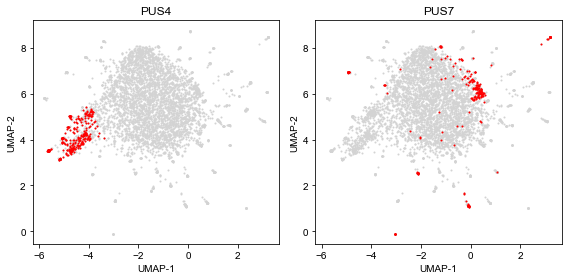

In [15]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
ax = axes[0]
ax.scatter(df_psi["X"], df_psi["Y"], s=1, lw=None, c="lightgray")
ax.scatter(df_psi.loc[df_psi["PUS"] == "pus4", "X"], df_psi.loc[df_psi["PUS"] == "pus4", "Y"], s=1, lw=None, c="red")
ax.set_title("PUS4")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

ax = axes[1]
ax.scatter(df_psi["X"], df_psi["Y"], s=1, lw=None, c="lightgray")
ax.scatter(df_psi.loc[df_psi["PUS"] == "pus7", "X"], df_psi.loc[df_psi["PUS"] == "pus7", "Y"], s=1, lw=None, c="red")
ax.set_title("PUS7")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("PUS4_PUS7.pdf")

### 1.2.1 Try cluster_selection_method='eom', soft clustering, we will found dozons of outliers

HDBSCAN soft clustering time: 0.21930575370788574 sec
HDBSCAN soft clustering RAM: 85.47766208648682 Mb
HDBSCAN cluster number: 3
Cluster
-1    1149
 1     264
 2     159
 3    3301
Name: Cluster, dtype: int64


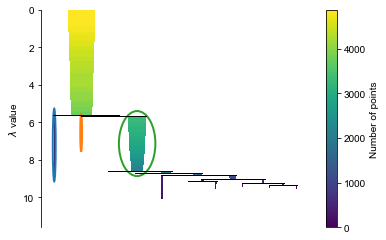

In [16]:
_, _, df_psi, _= cluster_HDBSCAN(df_psi, min_cluster_size=100, min_samples=10 , soft_clustering=False)

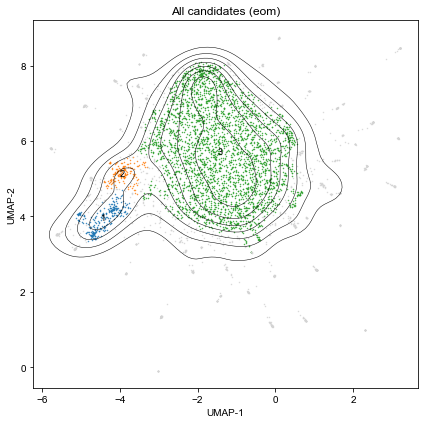

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_psi, title="All candidates (eom)")
plt.tight_layout()
plt.savefig("Psi_all.eom.png", dpi=300)

### 1.2.2 Extract outliers first

In [18]:
df_outliers = df_psi[df_psi["Cluster"]==-1]
extract_fasta_and_draw_motifs("Psi_outliers", df_outliers)

===============  Psi_outliers ===============
Cluster #-1: 1149


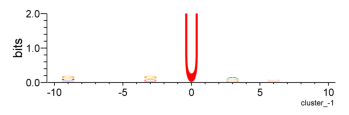

In [19]:
show_logos("./Psi_outliers/logos_bits_png/")

**Use MEME to scan possible missing motifs in outliers.**

In [20]:
# skipped here

# CE mode
#!meme -rna -objfun ce -cefrac 0.1 -nmotifs 5 -minw 5 -maxw 10 -oc ./Psi_outliers/outliers_meme_ce ./Psi_outliers/fasta/cluster_-1.fa

# CD mode
#!meme -rna -objfun cd -cefrac 0.1 -nmotifs 5 -minw 5 -maxw 10 -oc ./Psi_outliers/outliers_meme_cd ./Psi_outliers/fasta/cluster_-1.fa

# Normal mode
#!meme -rna -nmotifs 5 -minw 5 -maxw 10 -oc ./Psi_outliers/outliers_meme ./Psi_outliers/fasta/cluster_-1.fa

**We discard unclassified sites for better presentation.**

In [21]:
df_psi_1 = df_psi.drop(df_outliers.index, inplace=False).copy()
print(df_psi_1.shape)

(3724, 9)


### 1.2.3 Extract small clusters in cluster \#2

HDBSCAN soft clustering time: 0.4125382900238037 sec
HDBSCAN soft clustering RAM: 124.50746250152588 Mb
HDBSCAN cluster number: 9
Cluster
1     264
2     159
4     219
5     385
6     570
7    1293
8     479
9     355
Name: Cluster, dtype: int64


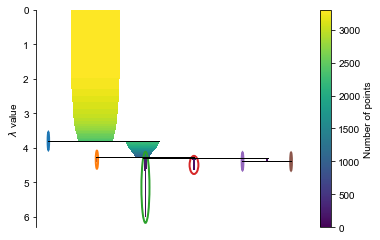

In [22]:
_, _, df_psi_1, _ = subcluster_HDBSCAN(df_psi_1, target=3, cluster_col="Cluster", min_cluster_size=30, min_samples=10, cluster_selection_epsilon=0.0, alpha=1., cluster_selection_method='leaf', draw_condensed_tree=True, soft_clustering=True)

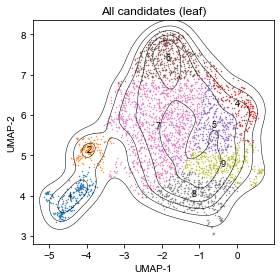

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_psi_1, title="All candidates (leaf)",)
plt.tight_layout()
plt.savefig("Psi_clean.leaf.png", dpi=300)

In [24]:
if df_psi_1["Cluster"].max() < 50:
    extract_fasta_and_draw_motifs("Psi_leaf", df_psi_1)

===============  Psi_leaf ===============
Cluster #1: 264
Cluster #2: 159
Cluster #4: 219
Cluster #5: 385
Cluster #6: 570
Cluster #7: 1293
Cluster #8: 479
Cluster #9: 355


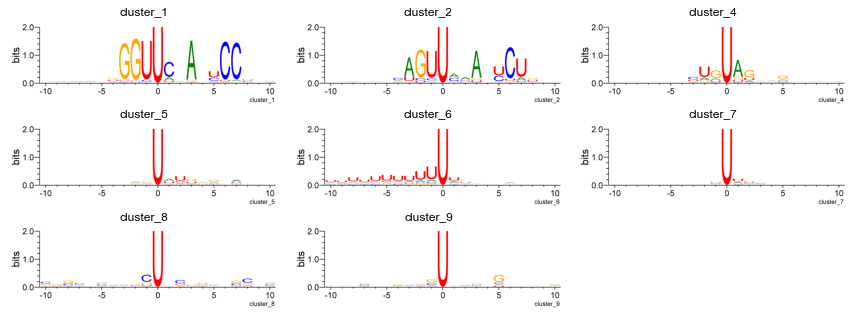

In [25]:
show_logos_cols("./Psi_leaf/logos_bits_png/", cols=3)

### Breif summary

1. Cluster \#1 and \#2 are GUUCA motif, which is similar to PUS4's. These two clusters match the positions of known PUS4 sites.
2. Cluster \#4 is in UGUAG, this motif is from PUS7.
5. Cluster \#6 is in a long U-track and probably false positive.
4. Cluster \#5, #\7 to \#9 have no significant enricment in bases.
5. Unclassified sites, no specific motif were found in meme.

Then we can merge the clusters.

In [26]:
df_psi_1.loc[df_psi_1["Cluster"].isin([1, 2]), "Cluster"] = 1  # PUS4
df_psi_1.loc[df_psi_1["Cluster"].isin([4]), "Cluster"] = 2  # PUS7
df_psi_1.loc[df_psi_1["Cluster"].isin([6]), "Cluster"] = 3  # Unknown
df_psi_1.loc[df_psi_1["Cluster"]>3, "Cluster"] = 4   # Probably noise

Cluster
1     423
2     219
3     570
4    2512
Name: Cluster, dtype: int64


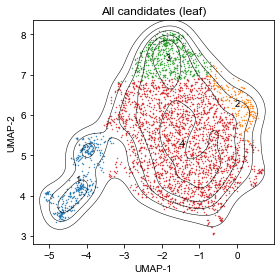

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_psi_1, title="All candidates (leaf)",)
plt.tight_layout()
plt.savefig("Psi_clean.leaf.recluster_2.png", dpi=300)
plt.savefig("Psi_clean.leaf.recluster_2.pdf", dpi=300)
print(df_psi_1.groupby("Cluster")["Cluster"].count())

In [28]:
extract_fasta_and_draw_motifs("Psi_methods_2", df_psi_1)

===============  Psi_methods_2 ===============
Cluster #1: 423
Cluster #2: 219
Cluster #3: 570
Cluster #4: 2512


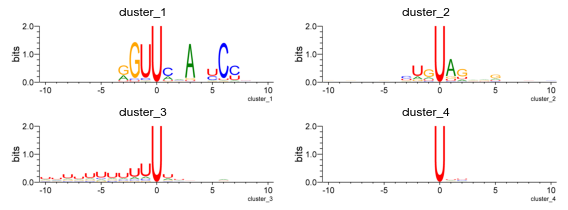

In [29]:
show_logos_cols("./Psi_methods_2/logos_bits_png/", cols=2)

## 1.3 Compare methods

In [30]:
common_contour_xx, common_contour_yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([common_contour_xx.ravel(), common_contour_yy.ravel()])
values = np.vstack([df_psi_1["X"], df_psi_1["Y"]])
kernel = scipy.stats.gaussian_kde(values)
common_contour_f = np.reshape(kernel(positions).T, common_contour_xx.shape)

Drawing Psi-seq_Carlile
Drawing Psi-seq_Schwart
Drawing CeU-seq
Drawing RBS-seq


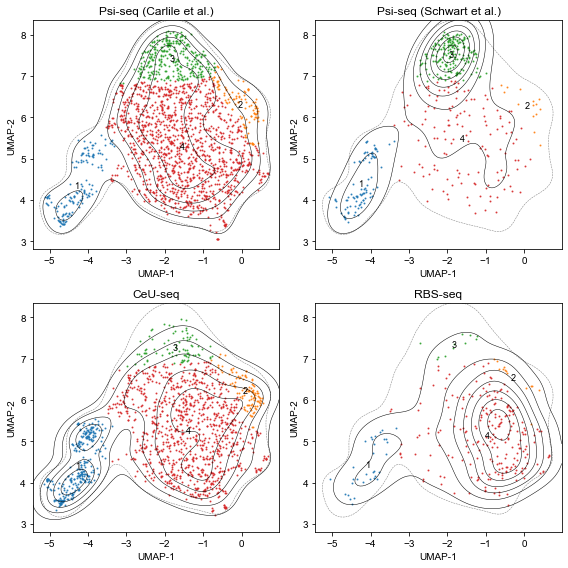

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

sample_titles = ["Psi-seq (Carlile et al.)", "Psi-seq (Schwart et al.)", "CeU-seq", "RBS-seq"]
sample_names = ["Psi-seq_Carlile", "Psi-seq_Schwart", "CeU-seq", "RBS-seq"]

# note: adjsut save_contour_diameter to keep the outest contour
for ax, title, samples in zip(*[axes.reshape(-1), sample_titles, sample_names]):
    draw_methods(ax, df_psi_1, save_contour_diameter=6, s=1, alpha=0.8, title=title, target=samples, common_contour_xx=common_contour_xx, common_contour_yy=common_contour_yy, common_contour_f=common_contour_f, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
plt.tight_layout()
plt.savefig("Psi_methods.pdf")

In [32]:
def draw_cluster_percentage(ax, df, title=None):
    df_analysis = df[[i for i in df.columns if i not in ["X", "Y", "Cluster", "Group"] ]].copy()
    df_analysis["Cluster"] = df["Cluster"]

    df_groupby = df_analysis.groupby("Cluster").sum()
    df_groupby.to_csv(title.replace(".","_")+".count.csv")
    
    df_groupby = df_groupby/(df_groupby.sum(axis=0) + 0.) * 100.

    df_groupby = df_groupby.T
    df_groupby.plot(kind="bar", stacked=True, ax=ax, width=0.9)
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)
    sns.despine()
    # ax.set_title(title)
    plt.xticks(rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.0, 0.5), title="Cluster", loc='center left')
    df_groupby.to_csv(title.replace(".","_")+".percent.csv")

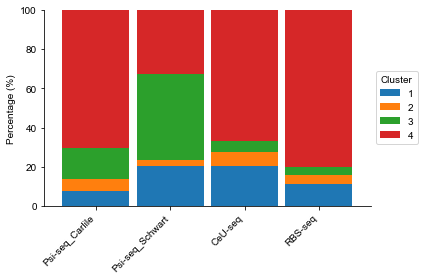

In [33]:
fig, ax = plt.subplots(figsize=(6,4))
draw_cluster_percentage(ax, df_psi_1, "Human")
plt.tight_layout()
plt.savefig("Human_psi_percentage.pdf")

## 1.4 Save table to disk

In [34]:
df_psi_1.to_csv("Psi_methods.clustered.csv")

## 2. Analyzing Yeast pseudoU

- Psi-seq, Yeast, mRNA+rRNA sites (Carlile et al.) (doi:10.1038/nature13802)
- Psi-seq, Yeast, mid-log and heatshock (Schwartz et al.) (doi:10.1016/j.cell.2014.08.028)

In [35]:
all_sequences = {}
dfs = []
PUS_dict = {}
load_sequences_from_fasta_or_csv("Schwartz_yeast_heatshock_1based.F10.fa", "Yeast_Schwartz_heatshock")
load_sequences_from_fasta_or_csv("Schwartz_yeast_midlog_1based.F10.fa", "Yeast_Schwartz_midlog")
load_sequences_from_fasta_or_csv("Carlie_yeast_mRNA_rRNA.F10.fa", "Yeast_Carlie")

df_psi_yeast = pd.concat(dfs, axis=1)
df_psi_yeast.fillna(False, inplace=True)
df_psi_yeast["motif_F10"] = df_psi_yeast.apply(lambda x: all_sequences.get(x.name), axis=1)
print(df_psi_yeast)

                 Yeast_Schwartz_heatshock  Yeast_Schwartz_midlog  \
chrII@681409@-                       True                  False   
chrII@681235@-                       True                  False   
chrII@680966@-                       True                  False   
chrXII@454406@-                      True                  False   
chrXII@462128@-                      True                  False   
...                                   ...                    ...   
chrXII@456552@-                     False                  False   
chrXII@456546@-                     False                  False   
chrXII@456542@-                     False                  False   
chrXII@454222@-                     False                  False   
chrXII@454140@-                     False                  False   

                 Yeast_Carlie              motif_F10  
chrII@681409@-          False  AATGGTGCTATAGTAGGTTGG  
chrII@681235@-          False  TTTTTTGATGTAATAGGATAA  
chrII@680966@-    

## 2.1 Test UMAP and DensMAP

In [36]:
onehot_input_psi_yeast = []
for idx, row in df_psi_yeast.iterrows():
    onehot_input_psi_yeast.append(onehot_enc(row))
onehot_input_psi_yeast = np.array(onehot_input_psi_yeast)

**Notably, DensMap is a better choice if too few sites were analyzed.**

In [37]:
_, _, df_psi_yeast_norm = UMAP(onehot_input_psi_yeast, df_psi_yeast, min_dist=0.01, n_neighbors=20, verbose=True, densmap=False)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Thu Jan 20 22:24:28 2022 Construct fuzzy simplicial set
Thu Jan 20 22:24:29 2022 Finding Nearest Neighbors
Thu Jan 20 22:24:32 2022 Finished Nearest Neighbor Search
Thu Jan 20 22:24:34 2022 Construct embedding



Thu Jan 20 22:24:36 2022 Finished embedding
UMAP time: 8.212779521942139 sec
UMAP RAM: 119.85086727142334 MB



In [38]:
_, _, df_psi_yeast_dens = UMAP(onehot_input_psi_yeast, df_psi_yeast, min_dist=0.01, n_neighbors=100, verbose=True, densmap=True)

UMAP
UMAP(densmap=True, init='random', min_dist=0.01, n_neighbors=100, random_state=42, verbose=True)
Thu Jan 20 22:24:36 2022 Construct fuzzy simplicial set
Thu Jan 20 22:24:37 2022 Finding Nearest Neighbors
Thu Jan 20 22:24:37 2022 Finished Nearest Neighbor Search
Thu Jan 20 22:24:37 2022 Construct embedding
Thu Jan 20 22:24:37 2022 Computing original densities



Thu Jan 20 22:24:49 2022 Finished embedding
UMAP time: 12.778589010238647 sec
UMAP RAM: 678.3395500183105 MB



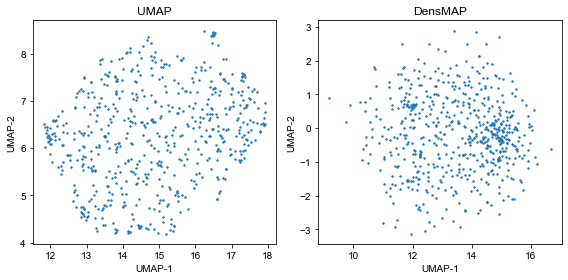

In [39]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].scatter(df_psi_yeast_norm["X"], df_psi_yeast_norm["Y"], s=2, lw=None)
axes[1].scatter(df_psi_yeast_dens["X"], df_psi_yeast_dens["Y"], s=2, lw=None)
axes[0].set_title("UMAP")
axes[1].set_title("DensMAP")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("Compare_UMAP_DensMAP.pdf")

## 2.2 Clustering

HDBSCAN soft clustering time: 0.06748437881469727 sec
HDBSCAN soft clustering RAM: 662.6717176437378 Mb
HDBSCAN cluster number: 4
Cluster
1    114
2    102
3    240
4    149
Name: Cluster, dtype: int64


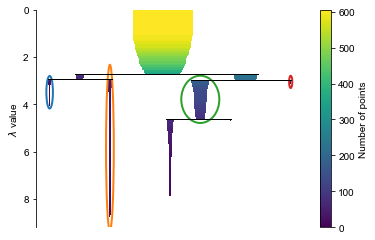

In [40]:
_, _, df_psi_yeast_dens, _= cluster_HDBSCAN(df_psi_yeast_dens, min_cluster_size=10, min_samples=10 , soft_clustering=True)

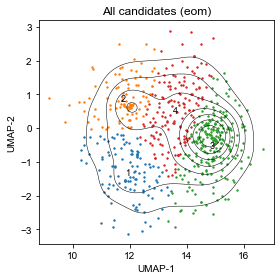

In [41]:
fig, ax = plt.subplots(figsize=(4,4))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_psi_yeast_dens, title="All candidates (eom)", s=2, alpha=1.)
plt.tight_layout()
plt.savefig("Psi_all_yeast.eom.png", dpi=300)

In [42]:
extract_fasta_and_draw_motifs("Psi_Yeast", df_psi_yeast_dens)

===============  Psi_Yeast ===============
Cluster #1: 114
Cluster #2: 102
Cluster #3: 240
Cluster #4: 149


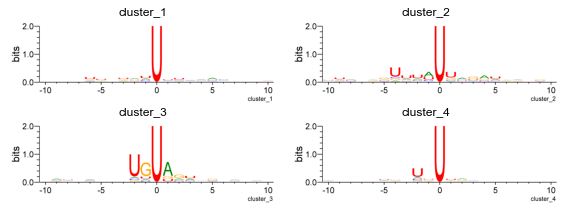

In [43]:
show_logos_cols("./Psi_Yeast/logos_bits_png/", cols=2)

- Cluster \#1 ?
- Cluster \#2 PUS4
- Cluster \#3 PUS7
- Cluster \#4 PUS2

## 3. Compare batches/conditions

In [44]:
common_contour_xx, common_contour_yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([common_contour_xx.ravel(), common_contour_yy.ravel()])
values = np.vstack([df_psi_yeast_dens["X"], df_psi_yeast_dens["Y"]])
kernel = scipy.stats.gaussian_kde(values)
common_contour_f = np.reshape(kernel(positions).T, common_contour_xx.shape)

Drawing Yeast_Schwartz_heatshock
Drawing Yeast_Schwartz_midlog
Drawing Yeast_Carlie


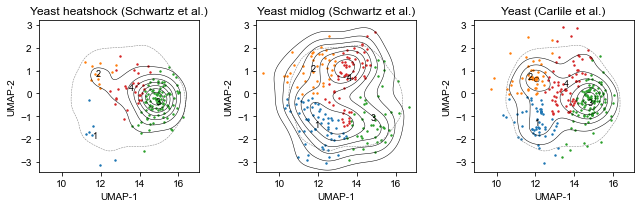

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

sample_titles = ["Yeast heatshock (Schwartz et al.)", "Yeast midlog (Schwartz et al.)", "Yeast (Carlile et al.)"]
sample_names = ["Yeast_Schwartz_heatshock", "Yeast_Schwartz_midlog", "Yeast_Carlie"]

# note: adjsut save_contour_diameter to keep the outest contour
for ax, title, samples in zip(*[axes.reshape(-1), sample_titles, sample_names]):
    draw_methods(ax, df_psi_yeast_dens, save_contour_diameter=5.5, s=2, alpha=1., title=title, target=samples, common_contour_xx=common_contour_xx, common_contour_yy=common_contour_yy, common_contour_f=common_contour_f, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
plt.tight_layout()
plt.savefig("Psi_Yeast.conditions.pdf")

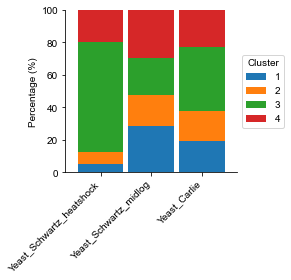

In [46]:
fig, ax = plt.subplots(figsize=(4,4))
draw_cluster_percentage(ax, df_psi_yeast_dens, "Yeast")
plt.tight_layout()
plt.savefig("Yeast_psi_percentage.pdf")